[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SolanaO/SparkNLP_Study/blob/master/Healthcare_SparkNLP_Equine_Dataset_Study.ipynb)

# Introduction

Use Healthcare Spark NLP pretrained models to identify topics on a set of about 1000 items extracted from querying Google Scholar on the subject of equine colic.

# Preliminaries

## Workspace Setup

In [1]:
!pip install -q stylecloud

In [2]:
# Importing the neccessary libraries
import json
import os

import re
import random

import numpy as np
import pandas as pd

from wordcloud import (
    WordCloud,
    ImageColorGenerator,
    STOPWORDS)
import stylecloud

# Libraries and options for graphs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

colors = sns.color_palette('PuBuGn')

# Options to display pandas dataframes
pd.options.display.max_colwidth = None
pd.options.display.float_format = '${:,.3f}'.format

In [3]:
# License keys settings neccessary to work in Healthcare Spark NLP
# as given in the JSL notebooks

from google.colab import files

license_keys = files.upload()

with open(list(license_keys.keys())[0]) as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

Saving spark_nlp_for_healthcare_spark_ocr_4811.json to spark_nlp_for_healthcare_spark_ocr_4811.json


In [4]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.1.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display

In [5]:
# Importing Spark libraries and modules

import sparknlp
import sparknlp_jsl

from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *

from sparknlp.pretrained import PretrainedPipeline

# Module to display ner results 
from sparknlp_display import NerVisualizer
visualiser = NerVisualizer()

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline,PipelineModel

from pyspark.sql.functions import desc, row_number, monotonically_increasing_id
from pyspark.sql.window import Window
from pyspark.sql.functions import concat_ws
from pyspark.sql.functions import collect_list

# Settings and parameters for the Spark session
# As included in JSL notebooks

import warnings
warnings.filterwarnings('ignore')

params = {"spark.driver.memory":"16G", 
          "spark.kryoserializer.buffer.max":"2000M", 
          "spark.driver.maxResultSize":"2000M"} 

print("Spark NLP Version :", sparknlp.version())
print("Spark NLP_JSL Version :", sparknlp_jsl.version())

# Staring Healthcare Spark NLP session
spark = sparknlp_jsl.start(license_keys['SECRET'], params=params)
spark

Spark NLP Version : 3.4.2
Spark NLP_JSL Version : 3.5.0


## Data Import

In [6]:
# Importing the collection of clean titles
!wget -q https://raw.githubusercontent.com/SolanaO/SparkNLP_Study/master/data/clean_titles.csv
# Save as a spark dataframe
titles_df = spark.createDataFrame(pd.read_csv("clean_titles.csv", index_col=0).reset_index())
# Inspect the data
titles_df.show(4, truncate=False)

+-----+--------------------------------------------------------------------------------------------------------------------------------------------+
|index|text                                                                                                                                        |
+-----+--------------------------------------------------------------------------------------------------------------------------------------------+
|0    |Prospective study of equine colic risk factors                                                                                              |
|1    | Dietary and other management factors associated with equine colic                                                                          |
|2    |Prospective study of equine colic incidence and mortality                                                                                   |
|3    |Case-control study of the association between various management factors and development of colic i

In [7]:
# Importing the collection of clean augmented titles
!wget -q https://raw.githubusercontent.com/SolanaO/SparkNLP_Study/master/data/clean_augm_titles.csv
# Save as a pandas dataframe
augm_df = spark.createDataFrame(pd.read_csv('clean_augm_titles.csv', index_col=0).reset_index())
# Inspect the data
augm_df.show(4, truncate=False)

+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|index|text                                                                                                                                                                                                                                                                                                                                 |
+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [8]:
# Importing the sample text
!wget -q https://raw.githubusercontent.com/SolanaO/SparkNLP_Study/master/data/sample_text_short.txt

In [9]:
# Read the text file
with open('./sample_text_short.txt') as f:
    sample_text_short = f.read()

## Useful Functions

In [10]:
def display_results(result):
    '''
    Function to extract results from .fullAnnotate() of the
    LightPipeline as a pandas dataframe.
    '''
    
    chunks = []
    entities = []
    sentence= []
    begin = []
    end = []

    for n in result[0]['ner_chunk']:
        
        chunks.append(n.result)
        begin.append(n.begin)
        end.append(n.end)
        entities.append(n.metadata['entity']) 
        sentence.append(n.metadata['sentence'])
    

    df_results = pd.DataFrame({'chunk':chunks,
                               'begin': begin, 'end':end,
                               'sent_id':sentence,
                               'entities':entities})

    return df_results

In [11]:
def display_key_phrase_results(result):
    '''
    Function to extract results from .fullAnnotate() of the
    key phrase extract LightPipeline as a pandas dataframe.
    '''
    
    chunks = []
    sentence= []
    entities = []
    docsim = []
    score = []

    for n in result[0]['ner_key_phrases']:
        
        chunks.append(n.result)
        sentence.append(n.metadata['sentence'])
        entities.append(n.metadata['entity']) 
        docsim.append(n.metadata['DocumentSimilarity'])
        score.append(n.metadata['MMRScore'])

    df_results = pd.DataFrame({'key_phrase':chunks, 
                   'sent_id':sentence, 'entity':entities,
                   'docsim': docsim, 'MMRScore': score})

    return df_results.sort_values(by=['sent_id'], ascending=True)

In [12]:
# Display the pipeline's output in spark DF form

def display_results_sparkDF(df):
    '''
    Function to select and display the output of a pipeline as a spark dataframe.
    The dataframe must have column: ner_key_phrases.
    df - output of pipeline.fit(empty_df).transform(input_df)
    '''

    results_pds = df \
        .select(df.index, df.text, \
         F.explode(F.arrays_zip("ner_key_phrases.result",
                                "ner_key_phrases.metadata")).alias('cols')) \
        .select(df.index, df.text, F.expr("cols['0']").alias('key_phrase'),
            F.expr("cols['1']['entity']").alias("label"),
            F.expr("cols['1']['DocumentSimilarity']").alias("DocumentSimilarity"),
            F.expr("cols['1']['MMRScore']").alias("MMRScore"),
            F.expr("cols['1']['sentence']").alias("sentence"))

    return results_pds

# NER Pretrained Pipelines on Short Text

## Pretrained Pipelines on Short Text

We test two of the main pretrained pipelines on a sample text to gather information on how these pipeline work on our type of *data*.

In [13]:
# Text to analyze
sample_text_short

'Coastal Bermuda hay is associated with impactions in this most distal segment of the small intestine, although it is difficult to separate this risk factor from geographic location, since the southeastern United States has a higher prevalence of ileal impaction and also has regional access to coastal Bermuda hay. Other causes can be obstruction by ascarids (Parascaris equorum), usually occurring at 3–5 months of age right after deworming. \n'

In [14]:
# Check the clinical_ner pretrained pipeline

pipeline = PretrainedPipeline("ner_clinical_pipeline", "en", "clinical/models")

test_ner_clinical = display_results(pipeline.fullAnnotate(sample_text_short))

ner_clinical_pipeline download started this may take some time.
Approx size to download 1.6 GB
[OK!]


In [15]:
# Check the ner_jsl pretrained pipeline

pipeline = PretrainedPipeline("ner_jsl_pipeline", "en", "clinical/models")

test_ner_jsl = display_results(pipeline.fullAnnotate(sample_text_short))

ner_jsl_pipeline download started this may take some time.
Approx size to download 1.6 GB
[OK!]


In [16]:
# Check the ner_jsl with bert_embeddings pretrained pipeline

pipeline = PretrainedPipeline("ner_jsl_biobert_pipeline", "en", "clinical/models")

test_ner_jsl_biobert = display_results(pipeline.fullAnnotate(sample_text_short))

ner_jsl_biobert_pipeline download started this may take some time.
Approx size to download 403.2 MB
[OK!]


Display the results side by side:

In [17]:
from google.colab import widgets

t = widgets.TabBar(["ner_clinical", "ner_jsl", "ner_bert"])

with t.output_to(0):
    display(test_ner_clinical)

with t.output_to(1):
    display(test_ner_jsl)

with t.output_to(2):
    display(test_ner_jsl_biobert)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,chunk,begin,end,sent_id,entities
0,impactions in this most distal segment,39,76,0,PROBLEM
1,ileal impaction,246,260,0,PROBLEM
2,obstruction,335,345,1,PROBLEM
3,ascarids,350,357,1,PROBLEM
4,Parascaris equorum,360,377,1,PROBLEM
5,deworming,432,440,1,TREATMENT


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,chunk,begin,end,sent_id,entities
0,Coastal Bermuda hay,0,18,0,Disease_Syndrome_Disorder
1,impactions in this most distal segment of the small intestine,39,99,0,Symptom
2,ileal impaction,246,260,0,Disease_Syndrome_Disorder
3,obstruction by ascarids (Parascaris equorum,335,377,1,Symptom
4,3–5 months of age,402,418,1,Age


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,chunk,begin,end,sent_id,entities
0,impactions,39,48,0,Symptom
1,distal,63,68,0,Direction
2,small intestine,85,99,0,Internal_organ_or_component
3,ileal impaction,246,260,0,Disease_Syndrome_Disorder
4,obstruction,335,345,1,Symptom
5,ascarids,350,357,1,Disease_Syndrome_Disorder
6,Parascaris equorum,360,377,1,Disease_Syndrome_Disorder
7,3–5 months of age,402,418,1,Age
8,deworming,432,440,1,Procedure


<IPython.core.display.Javascript object>

The `ner_clinical` correctly identifies all the chuncks, but we are looking for a model with more granularity. Although most of the entities are corectly identified, there are chunks such as *coastal Bermuda hay* and *ascarides* that are misinterpreted by `both ner_jsl` and `ner_jsl_biobert` pipelines. We check if there is a pretrained model which recognizes such chunks. This is accomplished via the pretrained model finder as given below.

## Use the Pretrained Model Finder

In [18]:
# Find a pretrained model that identifies organisms and forage
ner_pipeline = PretrainedPipeline("ner_model_finder", "en", "clinical/models")

result = ner_pipeline.annotate("Bermuda hay")
result

Approx size to download 148.6 MB
[OK!]


{'model_names': ["['ner_medmentions_coarse']"]}

In [19]:
# Check the output of the suggested pipeline

pipeline = PretrainedPipeline("ner_medmentions_coarse_pipeline", "en", "clinical/models")

test_ner_med = display_results(pipeline.fullAnnotate(sample_text_short))
test_ner_med

ner_medmentions_coarse_pipeline download started this may take some time.
Approx size to download 1.6 GB
[OK!]


,chunk,begin,end,sent_id,entities
0,Coastal Bermuda hay,0,18,0,Food
1,associated with,23,37,0,Qualitative_Concept
2,impactions,39,48,0,Disease_or_Syndrome
3,distal segment,63,76,0,Body_Location_or_Region
4,small intestine,85,99,0,"Body_Part,_Organ,_or_Organ_Component"
5,geographic location,161,179,0,Spatial_Concept
6,southeastern United States,192,217,0,Geographic_Area
7,prevalence,232,241,0,Quantitative_Concept
8,ileal impaction,246,260,0,Disease_or_Syndrome
9,regional access,275,289,0,Spatial_Concept


This pretrained model identifies the entities quite well, we'll build the pipeline around it.

# NER Pipeline with KeyPhraseExtraction and Relabeled Entities

We include a stopwords removal annotator, to drop the words *equine* and *colic* which appear in most of the documents, due to the fact that the data is obtained by quering these terms.

We want these words to be removed before the `NerModel` analyzes the data, thus we are using StopWordsCleaner() annotator and not the option `.setBlackList` within the `NerConverterInternal()` annotator. The latter would just remove the words after the items are labelled with entities, so the masking would not affect the clustering, but only the key phrase extraction. 



In [20]:
# Create a dictionary of original labels and their new versions
replace_labels_dict = """Disease_or_Syndrome,Disease_and_Symptoms
Sign_or_Symptom,Disease_and_Symptoms
Substance,Disease_and_Symptoms

Therapeutic_or_Preventive_Procedure,Treatment_or_Diagnostic
Diagnostic_Procedure,Treatment_or_Diagnostic

Health_Care_Activity,Medical_or_Preventive_Procedure
Laboratory_Procedure,Medical_or_Preventive_Procedure
Chemical,Medical_or_Preventive_Procedure
Prokaryote,Medical_or_Preventive_Procedure
Organic_Chemical,Medical_or_Preventive_Procedure
Medical_Device,Medical_or_Preventive_Procedure
Clinical_Attribute,Medical_or_Preventive_Procedure
Biomedical_or_Dental_Material,Medical_or_Preventive_Procedure

Pathologic_Function,Biological_Aspects
Biologic_Function,Biological_Aspects
Cell,Biological_Aspects
Neoplastic_Process,Biological_Aspects
Molecular_Function,Biological_Aspects
Pharmacologic_Substance,Biological_Aspects
Gene_or_Genome,Biological_Aspects
Organism_Attribute,Biological_Aspects

Body_Substance,Body_Related
Tissue,Body_Related
Body_Location_or_Region,Body_Related
Body_System,Body_Related
Anatomical_Structure,Body_Related

Manufactured_Object,Human_Related_Activities
Research_Activity,Human_Related_Activities
Quantitative_Concept,Human_Related_Activities
Professional_or_Occupational_Group,Human_Related_Activities
Population_Group,Human_Related_Activities
Daily_or_Recreational_Activity,Human_Related_Activities
Organization,Human_Related_Activities
Spatial_Concept,Human_Related_Activities
Mental_or_Behavioral_Dysfunction,Human_Related_Activities
Mental_Process,Human_Related_Activities

Qualitative_Concept,Forage_Related
Geographic_Area,Forage_Related
Injury_or_Poisoning,Forage_Related
Plant,Forage_Related
Food,Forage_Related

Mammal,Parasites_Related
Eukaryote,Parasites_Related
"""
# Save the correspondence dictionary in a file
with open('replace_dict.csv', 'w') as f:
    f.write(replace_labels_dict)

In [21]:
# Full Pipeline Stages

# Prepare data into a format processable by Spark NLP
document_assembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

# Detect sentence boundaries in healthcare texts using DL
sentence_detector = SentenceDetectorDLModel\
    .pretrained("sentence_detector_dl_healthcare","en","clinical/models")\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

# Split raw text into words pieces in relevant format for NLP
tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

#Cleans the query words: equine and colic
words_cleaner = StopWordsCleaner()\
      .setInputCols("token")\
      .setOutputCol("cleanToken")\
      .setCaseSensitive(False)\
      .setStopWords(["equine", "colic"])

# Maps sentences and tokens to 200 dim vectors 
word_embeddings = WordEmbeddingsModel \
    .pretrained('embeddings_clinical', "en", "clinical/models")\
    .setInputCols(["sentence", "cleanToken"])\
    .setOutputCol("word_embeddings")

# Name entity recognition annotator 
med_ner = MedicalNerModel \
    .pretrained("ner_medmentions_coarse", "en", "clinical/models")\
    .setInputCols(["sentence", "cleanToken", "word_embeddings"])\
    .setOutputCol("ner_med")

# Use this converter to get the original labels
ner_converter_original= NerConverterInternal() \
    .setInputCols(["sentence", "cleanToken", "ner_med"]) \
    .setOutputCol("ner_chunk") 
    #.setBlackList(["equine", "colic"]) \

# Use this converter to get the combined labels
ner_converter_combined = NerConverterInternal()\
    .setInputCols(["sentence","cleanToken","ner_med"])\
    .setOutputCol("ner_chunk")\
    .setReplaceDictResource("replace_dict.csv","text", {"delimiter":","})

# Extract key phrases
ner_key_phrase_extractor = ChunkKeyPhraseExtraction \
    .pretrained()\
    .setTopN(1) \
    .setDocumentLevelProcessing(True) \
    .setDivergence(.7)\
    .setInputCols(["sentence", "ner_chunk"])\
    .setOutputCol("ner_key_phrases")

# Combine all the steps in a pipeline - keep original entities
pipeline_original = Pipeline(stages = [
    document_assembler,
    sentence_detector,
    tokenizer,
    words_cleaner,
    word_embeddings,
    med_ner,
    ner_converter_original,
    ner_key_phrase_extractor
    ])

# Combine all the steps in a pipeline - use replaced entities
pipeline_new = Pipeline(stages = [
    document_assembler,
    sentence_detector,
    tokenizer,
    words_cleaner,
    word_embeddings,
    med_ner,
    ner_converter_combined,
    ner_key_phrase_extractor
    ])

# Create an empty spark dataframe
empty_df = spark.createDataFrame([['']]).toDF("text")

# Create the original pipeline model object
pipe_model_original = pipeline_original.fit(empty_df)

# Create the combined pipeline model object
pipe_model_new = pipeline_new.fit(empty_df)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_medmentions_coarse download started this may take some time.
Approximate size to download 14.5 MB
[OK!]
sbert_jsl_medium_uncased download started this may take some time.
Approximate size to download 146.8 MB
[OK!]


In [22]:
# Print the classes for ner_medmentions_coarse
ner_med_classes = list(MedicalNerModel.pretrained('ner_medmentions_coarse', "en", "clinical/models").getClasses())

ner_medmentions_coarse download started this may take some time.
Approximate size to download 14.5 MB
[OK!]


In [23]:
# Print the number of entities
print(f'The "ner_medmentions_coarse" model has {len(ner_med_classes)} entities.')

The "ner_medmentions_coarse" model has 109 entities.


## Apply the Pipeline on Text Samples

In [24]:
# Create LightPipeline models
light_pipe_model_original = LightPipeline(pipe_model_original)
light_pipe_model_new = LightPipeline(pipe_model_new)

In [25]:
# Print the short text
sample_text_short

'Coastal Bermuda hay is associated with impactions in this most distal segment of the small intestine, although it is difficult to separate this risk factor from geographic location, since the southeastern United States has a higher prevalence of ileal impaction and also has regional access to coastal Bermuda hay. Other causes can be obstruction by ascarids (Parascaris equorum), usually occurring at 3–5 months of age right after deworming. \n'

In [26]:
# Get results from both pipelines on the sample text

result_original = light_pipe_model_original.fullAnnotate(sample_text_short)
original_short = display_results(result_original)

result_new = light_pipe_model_new.fullAnnotate(sample_text_short)
new_short = display_results(result_new)

In [27]:
from google.colab import widgets

t = widgets.TabBar(["result_original", "result_new",
                    "viz_original", "viz_new"])

with t.output_to(0):
    display(original_short)

with t.output_to(1):
    display(new_short)

# Initialize visualizer and create the visuals
visualiser = NerVisualizer()

with t.output_to(2):
    visualiser.display(result_original[0],
                       label_col='ner_chunk', document_col='document')

with t.output_to(3):
    visualiser.display(result_new[0], 
                       label_col='ner_chunk', document_col='document')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,chunk,begin,end,sent_id,entities
0,Coastal Bermuda hay,0,18,0,Food
1,associated with,23,37,0,Qualitative_Concept
2,impactions,39,48,0,Disease_or_Syndrome
3,distal segment,63,76,0,Body_Location_or_Region
4,small intestine,85,99,0,"Body_Part,_Organ,_or_Organ_Component"
5,geographic location,161,179,0,Spatial_Concept
6,southeastern United States,192,217,0,Geographic_Area
7,prevalence,232,241,0,Quantitative_Concept
8,ileal impaction,246,260,0,Disease_or_Syndrome
9,regional access,275,289,0,Spatial_Concept


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,chunk,begin,end,sent_id,entities
0,Coastal Bermuda hay,0,18,0,Forage_Related
1,associated with,23,37,0,Forage_Related
2,impactions,39,48,0,Disease_and_Symptoms
3,distal segment,63,76,0,Body_Related
4,small intestine,85,99,0,"Body_Part,_Organ,_or_Organ_Component"
5,geographic location,161,179,0,Human_Related_Activities
6,southeastern United States,192,217,0,Forage_Related
7,prevalence,232,241,0,Human_Related_Activities
8,ileal impaction,246,260,0,Disease_and_Symptoms
9,regional access,275,289,0,Human_Related_Activities


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Pipeline with Original Entities on Augmented Titles

In [28]:
# Apply the pipeline to the augumented titles Spark dataframe
results_original = pipe_model_original.transform(augm_df).cache()

In [29]:
# Display the results
original_pds = display_results_sparkDF(results_original)
original_pds.show(10)

+-----+--------------------+--------------------+--------------------+-------------------+-------------------+--------+
|index|                text|          key_phrase|               label| DocumentSimilarity|           MMRScore|sentence|
+-----+--------------------+--------------------+--------------------+-------------------+-------------------+--------+
|    0|Prospective study...|         horse farms| Manufactured_Object| 0.5393505371597437|0.16180516757748253|       1|
|    1| Dietary and othe...|             disease| Disease_or_Syndrome| 0.5382300470087011|0.16146902051881248|       1|
|    2|Prospective study...|         horse farms| Manufactured_Object| 0.4974248475569449|0.14922746019684974|       1|
|    3|Case-control stud...|              horses|              Mammal| 0.3811954733072219|0.11435864653637073|       0|
|    4| Practical guide ...|  patient management|Health_Care_Activity|0.27672174714520215|0.08301652744234093|       1|
|    5|A two year, prosp...|epidemiologi

In [30]:
# Rewrite the results as a pandas dataframe
#original_df_full = results_original.toPandas()
#original_df = original_pds.toPandas()

# Save the results in csv files
#original_df_full.to_csv("augm_titles_original_full.csv")
#original_df.to_csv("augm_titles_original.csv")

# Download the results files
#from google.colab import files
#files.download("augm_titles_original.csv")
#files.download("augm_titles_original_full.csv")

In [31]:
# Display the distribution of items on entities
original_count = original_pds.groupBy('label').count().sort(F.desc("count"))
original_count.show(46, truncate=False)

+---------------------------------------+-----+
|label                                  |count|
+---------------------------------------+-----+
|Disease_or_Syndrome                    |167  |
|Therapeutic_or_Preventive_Procedure    |88   |
|Manufactured_Object                    |61   |
|Health_Care_Activity                   |50   |
|Sign_or_Symptom                        |38   |
|Research_Activity                      |38   |
|Quantitative_Concept                   |35   |
|Pathologic_Function                    |35   |
|Organic_Chemical                       |34   |
|Mammal                                 |27   |
|Biologic_Function                      |25   |
|Eukaryote                              |22   |
|Body_Part,_Organ,_or_Organ_Component   |21   |
|Professional_or_Occupational_Group     |20   |
|Qualitative_Concept                    |19   |
|Injury_or_Poisoning                    |17   |
|Laboratory_Procedure                   |15   |
|Diagnostic_Procedure                   

## Pipeline with New Entities on Augmented Titles

In [32]:
# Apply the pipeline to the augumented titles Spark dataframe
results_new = pipe_model_new.transform(augm_df).cache()

In [33]:
# Display the results
new_pds = display_results_sparkDF(results_new)
new_pds.show(10)

+-----+--------------------+--------------------+--------------------+-------------------+-------------------+--------+
|index|                text|          key_phrase|               label| DocumentSimilarity|           MMRScore|sentence|
+-----+--------------------+--------------------+--------------------+-------------------+-------------------+--------+
|    0|Prospective study...|         horse farms|Human_Related_Act...| 0.5393505371597437|0.16180516757748253|       1|
|    1| Dietary and othe...|             disease|Disease_and_Symptoms| 0.5382300470087011|0.16146902051881248|       1|
|    2|Prospective study...|         horse farms|Human_Related_Act...| 0.4974248475569449|0.14922746019684974|       1|
|    3|Case-control stud...|              horses|   Parasites_Related| 0.3811954733072219|0.11435864653637073|       0|
|    4| Practical guide ...|  patient management|Medical_or_Preven...|0.27672174714520215|0.08301652744234093|       1|
|    5|A two year, prosp...|epidemiologi

In [34]:
# Rewrite the results as a pandas dataframe
#new_df_full = results_new.toPandas()
#new_df = new_pds.toPandas()

# Save the results in csv files
#new_df_full.to_csv("augm_titles_new_full.csv")
#new_df.to_csv("augm_titles_new.csv")

# Download the results files
#from google.colab import files
#files.download("augm_titles_new_full.csv")
#files.download("augm_titles_new.csv")

In [35]:
# Display the distribution of items on entities
new_count = new_pds.groupBy('label').count().sort(F.desc("count"))
new_count.show(16, truncate=False)

+---------------------------------------+-----+
|label                                  |count|
+---------------------------------------+-----+
|Disease_and_Symptoms                   |206  |
|Human_Related_Activities               |178  |
|Medical_or_Preventive_Procedure        |116  |
|Treatment_or_Diagnostic                |103  |
|Biological_Aspects                     |82   |
|Forage_Related                         |60   |
|Parasites_Related                      |49   |
|Body_Related                           |26   |
|Body_Part,_Organ,_or_Organ_Component   |21   |
|Amino_Acid,_Peptide,_or_Protein        |13   |
|Nucleic_Acid,_Nucleoside,_or_Nucleotide|1    |
+---------------------------------------+-----+



# Extract Topics for Each Entity

## Combine Items by Original Entities

Combine all the augmented titles that correspond to the same entity in a large document to extract the relevant combined key phrase.

In [36]:
# Collect all the items and create texts for each entity
original_lists = original_pds.groupby('label').agg(collect_list('text').alias("text"))
original_texts = original_lists.withColumn("text", concat_ws(", ", "text"))
original_texts.show(46, truncate=False)

+---------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [37]:
# Create a pyspark dataframe that contains only index and text columns
original_grouped = original_texts.withColumn('index', row_number().over(Window.orderBy(monotonically_increasing_id())) - 1)
original_combined_texts = original_grouped.select(original_grouped.index, original_grouped.text)
original_combined_texts.show(4)

+-----+--------------------+
|index|                text|
+-----+--------------------+
|    0| Epidemiological ...|
|    1| Primary decision...|
|    2| Practical guide ...|
|    3|The in vivo biody...|
+-----+--------------------+
only showing top 4 rows



In [38]:
# Apply the pipeline to extract key phrases for each text bulk
original_results_concat = pipe_model_original.transform(original_combined_texts).cache()

In [39]:
# Display the results
original_concat = display_results_sparkDF(original_results_concat)
original_concat.show(10)

+-----+--------------------+--------------------+--------------------+------------------+-------------------+--------+
|index|                text|          key_phrase|               label|DocumentSimilarity|           MMRScore|sentence|
+-----+--------------------+--------------------+--------------------+------------------+-------------------+--------+
|    0| Epidemiological ...|broader equine co...|    Population_Group|0.6211953657410539|  0.186358617127542|      18|
|    1| Primary decision...|    Prostaglandin E2|    Organic_Chemical|0.5562806350027706| 0.1668841971322131|       3|
|    2| Practical guide ...|Prognosis of Equi...|   Research_Activity|0.8300476235721077|0.24901429696657107|      23|
|    3|The in vivo biody...|       Vete1inarians|Mental_or_Behavio...|0.5100255758428041|0.15300767883281988|       4|
|    4|Implications of u...|          metabolite|            Chemical|0.5208451469843784|0.15625355030427152|       0|
|    5| Could it be coli...|Management of the...

In [41]:
# Rewrite the results as a pandas dataframe
#original_concat_full_df = original_results_concat.toPandas()
#original_concat_df = original_concat.toPandas()

# Save the results in csv files
#original_concat_full_df.to_csv("original_concat_full.csv")
#original_concat_df.to_csv("original_concat.csv")

# Download the results files
#from google.colab import files
#files.download("original_concat_full.csv")
#files.download("original_concat.csv")

## Combine Items by New Entities

In [42]:
# Collect all the items and create texts for each entity
new_lists = new_pds.groupby('label').agg(collect_list('text').alias("text"))
new_texts = new_lists.withColumn("text", concat_ws(", ", "text"))
new_texts.show(16, truncate=False)

+---------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [43]:
# Create a pyspark dataframe that contains only index and text columns
new_grouped = new_texts.withColumn('index', row_number().over(Window.orderBy(monotonically_increasing_id())) - 1)
new_combined_texts = new_grouped.select(new_grouped.index, new_grouped.text)
new_combined_texts.show(4)

+-----+--------------------+
|index|                text|
+-----+--------------------+
|    0|Development of a ...|
|    1|Prevention of pos...|
|    2| Practical guide ...|
|    3|Equine colic asso...|
+-----+--------------------+
only showing top 4 rows



In [44]:
# Apply the pipeline to extract key phrases for each text bulk
new_results_concat = pipe_model_new.transform(new_combined_texts).cache()

In [45]:
# Display the results
new_concat = display_results_sparkDF(new_results_concat)
new_concat.show(10)

+-----+--------------------+--------------------+--------------------+------------------+-------------------+--------+
|index|                text|          key_phrase|               label|DocumentSimilarity|           MMRScore|sentence|
+-----+--------------------+--------------------+--------------------+------------------+-------------------+--------+
|    0|Development of a ...| fatal equine colics|      Forage_Related|0.7629145473588945|0.22887437330231847|      19|
|    1|Prevention of pos...|Prognosis in equi...|Medical_or_Preven...|0.6931753031383668| 0.2079525992048036|       5|
|    2| Practical guide ...|vital for colic t...|Medical_or_Preven...|0.6357850387900675|0.19073551921616855|     122|
|    3|Equine colic asso...|left lobe of the ...|Body_Part,_Organ,...|0.5636935867316809|0.16910808273925548|      20|
|    4|Prospective study...|Whirl Equine Coli...|Human_Related_Act...| 0.737459002945982|0.22123770967499098|     161|
|    5| Dietary and othe...|TREATING ABDOMINA...

In [46]:
# Rewrite the results as a pandas dataframe
#new_concat_full_df = new_results_concat.toPandas()
#new_concat_df = new_concat.toPandas()

# Save the results in csv files
#new_concat_full_df.to_csv("new_concat_full.csv")
#new_concat_df.to_csv("new_concat.csv")

# Download the results files
#from google.colab import files
#files.download("new_concat_full.csv")
#files.download("new_concat.csv")

## Use Word Frequencies to Create Word Clouds for Key Phrases 

In [47]:
# Create combined lists for the key phrases that correspond to each label
grouped_original_keys = original_pds.groupby('label').agg(collect_list('key_phrase').alias("text"))
grouped_original_keys = grouped_original_keys.withColumn("text", concat_ws(",", "text"))

grouped_new_keys = new_pds.groupby('label').agg(collect_list('key_phrase').alias("text"))
grouped_new_keys = grouped_new_keys.withColumn("text", concat_ws(",", "text"))

# Rewrite the results pandas dataframes
original_keys_df = grouped_original_keys.toPandas()
new_keys_df = grouped_new_keys.toPandas()

# Save the results in csv files
#original_keys_df.to_csv("original_concat_keys.csv")
#new_keys_df.to_csv("new_concat_keys.csv")

# Download the results files
#from google.colab import files
#files.download("original_concat_keys.csv")
#files.download("new_concat_keys.csv")


In [48]:
# Get and update the stopwords to be removed from the wordcloud
stopwords = set(STOPWORDS)
stopwords.update(['equine', 'colic', 'horse', 'horses'])

In [49]:
import random

#function from https://amueller.github.io/word_cloud/auto_examples/a_new_hope.html
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 80)

In [50]:
import re 

def entityWordCloud(text, stopwords, width, height, margin):
    '''
    Function to create a wordcloud for the given text.
    '''

    # prepare the text
    text = re.sub(r"[^a-zA-Z0-9]", " ", text).strip()
    
    # create the word cloud
    wc = WordCloud(stopwords=stopwords, width=width, height=height,
                   margin=margin, random_state=42).generate(text)
    return wc

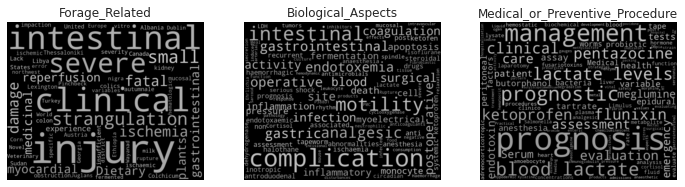

In [51]:
fig = plt.figure(figsize=(12,4))
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    wc = entityWordCloud(new_keys_df.text[i],stopwords,1000,800,0)
    # display the fitted and recolored wordcloud
    ax.imshow(wc.recolor(color_func=grey_color_func, random_state=42), 
               interpolation="bilinear")
    plt.title(new_keys_df.label[i])
    ax.axis('off')
    